In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import dabest
import pathlib as plb
from scipy.stats import norm

### Creating a test plot using only 2 conditions.
<p> Developing an understanding of the dataframe shape and configuration required by dabest for visualization of confidence intervals.</p>

In [2]:
### Read in data that contains unblinded compounds, chemotaxis indeces and worm totals
### for the entire screen. 
###This will be used to grab worm location files to generate confidence intervals.

screen_data = pd.read_csv('/Volumes/LaCie/_2021_03_screen/2103_data_unblinded.csv', index_col=0)
#screen_data.head()

In [32]:
#Creating a subset of the 2103 data using 1 control, 1 positive and 1 negative
#reference compound
test_comps = ['DMSO', 'Diacetyl', 'R(-)-Carvone']
subset =  screen_data.loc[screen_data['Compound Name'].isin(test_comps)]
#subset

In [10]:
#Generating a file path to dynamically read in worm location files
wrm_locs_fldr = plb.Path('/Volumes/LaCie/_2021_03_screen/_2021_03_automated_results/')

#### Creating a small plot for Diacetyl, DMSO and (-)Carvone using only 1 replicate.
<p> This is just to see how DaBest works using a small subset of the data

In [34]:
#Reading in the subset of worm locations
diacetyl_1 = pd.read_csv(wrm_locs_fldr.joinpath('loc_NPP_210319_POST_005_4B.csv'))
dmso_1 = pd.read_csv(wrm_locs_fldr.joinpath('loc_NPP_210319_POST_001_4D.csv'))
carvone_1 = pd.read_csv(wrm_locs_fldr.joinpath('loc_NPP_210319_POST_003_2A.csv'))

In [35]:
#Grabbing the data along only the x-axis of the image used to calculate the chemotaxis index
diacetyl_x1 = diacetyl_1['centroid-1']
dmso_x1 = dmso_1['centroid-1']
carvone_x1 = carvone_1['centroid-1']

In [36]:
#Dabest requires a dataframe object to calculate confidence intervals.
#Order is important! The first column in Dabest DF is used as the control
mini_df = pd.DataFrame({'dmso': dmso_x1, 'diacetyl': diacetyl_x1, 'carvone': carvone_x1 })
mini_df.head()

,dmso,diacetyl,carvone
0,568.0,738,787.0
1,1803.0,627,1656.0
2,792.0,1468,1608.0
3,2215.0,701,2462.0
4,1089.0,418,2414.0


In [37]:
# Loading the subset dataset to dabest.
# Using the unpaired mean differnce, which is the default value
# Also using the default vaule of bootstrap = 5000 
shared_control = dabest.load(mini_df, idx=("dmso", "diacetyl","carvone"))

# Calculating the mean difference of the worm locations relative to DMSO
shared_control.mean_diff

DABEST v0.2.6
             
Good afternoon!
The current time is Wed Jun  9 16:53:25 2021.

The unpaired mean difference between dmso and diacetyl is -3.37e+02 [95%CI -4.76e+02, -2.01e+02].
The two-sided p-value of the Mann-Whitney test is 1.25e-05.

The unpaired mean difference between dmso and carvone is 2.2e+02 [95%CI 58.8, 3.79e+02].
The two-sided p-value of the Mann-Whitney test is 0.0285.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`

In [38]:
#Heading the advice printed above and printing out the results from the statistical tests
shared_control.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,dmso,diacetyl,315,315,mean difference,False,-337.341325,95,-475.904324,-200.501259,0.000004,4.693672,0.000001,4.875732,0.000012,39239.0
1,dmso,carvone,315,315,mean difference,False,220.171390,95,58.831781,379.197873,0.007159,-2.709224,0.018705,-2.364131,0.028467,8669.5


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 39.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


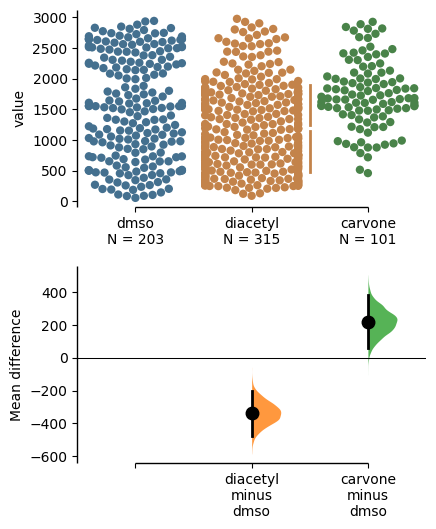

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


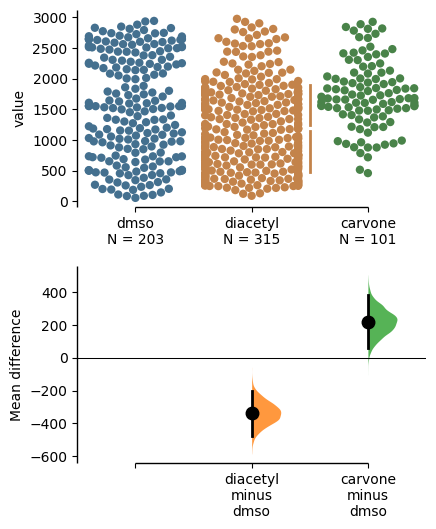

In [39]:
#Plotting the results from the mean difference analysis
shared_control.mean_diff.plot()

### But what if I want to pool the data from all 3 replicates for a given compound?
#### The following function will aggregate data for all replicates of a given compound
1. The following function will aggregate data for all 3 reps from both a subset of the data and the entire dataset.
2. The dataframe at line 23 can be changed to represent all of the data, not just the references and controls

In [8]:

def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound Name']
    xs = temp['centroid-1']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict


In [41]:
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in subset.iterrows():
    pooled_refs = get_worm_locs(row, wrm_locs_fldr, results_dict)

In [42]:
#Remember that Dabest requires a dataframe. Casting dict to df
pooled_refs_df = pd.DataFrame.from_dict(pooled_refs)
print(len(pooled_refs_df))

747


In [43]:
pooled_refs_obj = dabest.load(pooled_refs_df, idx=('DMSO','R(-)-Carvone', 'Diacetyl'))

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


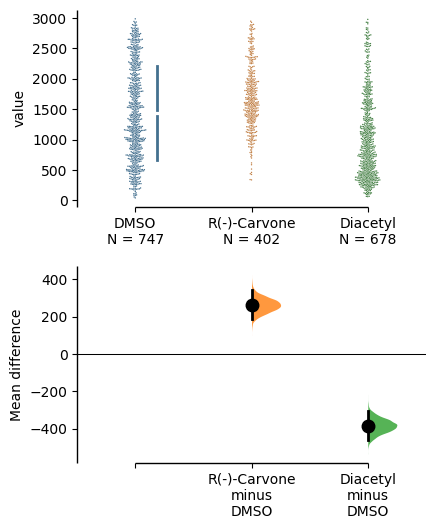

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


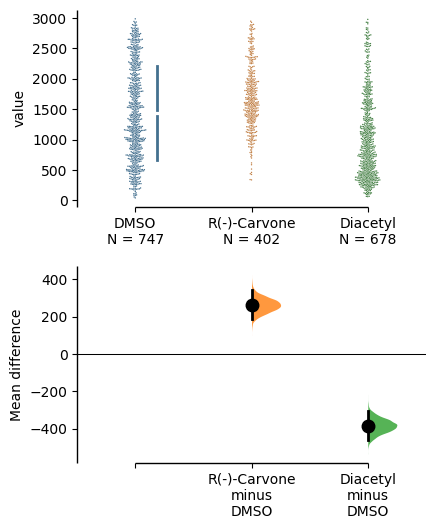

In [44]:
pooled_refs_obj.mean_diff.plot(raw_marker_size=1)

### Let's pull all of the data together from the most recent screen

In [45]:
allComps_dict = {}
for index, row in screen_data.iterrows():
    allComps = get_worm_locs(row, wrm_locs_fldr, allComps_dict)

all_comps_df = pd.DataFrame.from_dict(allComps)

In [54]:
all_comps_df.to_csv('/Volumes/LaCie/Worm2021_figs/worm_positions.csv')

In [46]:
### Creating a list of compound names to pass to Dabest. Reordering the list so the DMSO
### is the control
all_compounds = screen_data['Compound Name'].unique().tolist()
print(len(all_compounds))
all_compounds.insert(0, all_compounds.pop(all_compounds.index('DMSO')))
print(all_compounds[0])
print(len(all_compounds))

96
DMSO
96


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


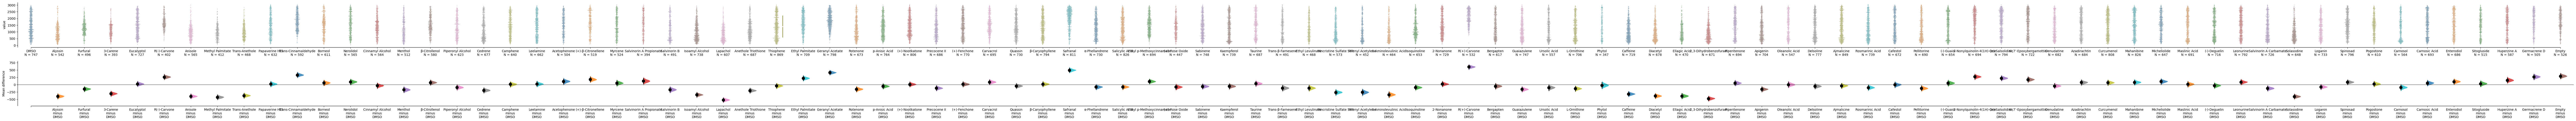

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


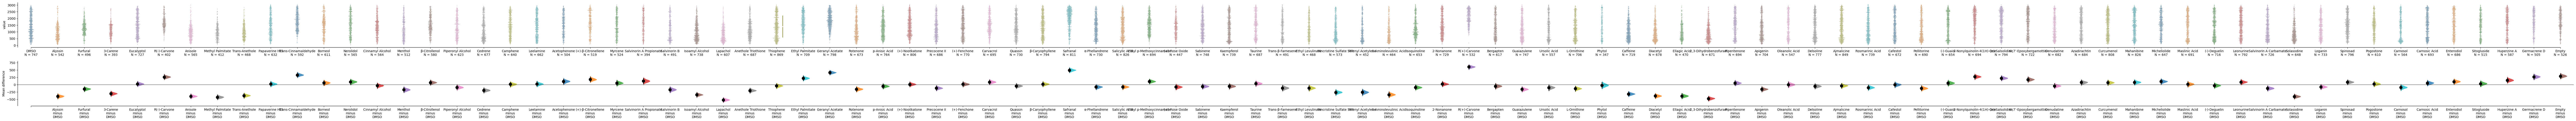

In [47]:
### Creating the dabest object and plotting using the entire 2103 dataset
all_comps_obj = dabest.load(all_comps_df, idx=(all_compounds))
all_comps_obj.mean_diff.plot(raw_marker_size=1)

In [50]:
conf_int_results = all_comps_obj.mean_diff.results

In [51]:
conf_int_results.to_csv('/Volumes/LaCie/Worm2021_figs/all_compound_interval.csv')

### Creating estimation plots of controls and refs only


In [16]:
agg_color_dict = ref_color_dict = {'DMSO': '#8E24AA' ,'Empty':'#512DA8','2-Nonanone': '#388E3C' , 'Diacetyl': '#F57F17','Isoamyl Alcohol':'#CB4335'}
ref_comps = ['DMSO', 'Empty','2-Nonanone', 'Diacetyl','Isoamyl Alcohol']
#pos = ['Diacetyl','Isoamyl Alcohol', 'DMSO', 'Empty','2-Nonanone', 'R(+)-Carvone' , 'R(-)-Carvone']
#neg = ['R(-)-Carvone', '2-Nonanone', 'R(+)-Carvone' , 'Diacetyl','Isoamyl Alcohol', 'DMSO', 'Empty' ]


In [17]:
refs = screen_data.loc[screen_data['Compound Name'].isin(ref_comps)]
refs.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Plate ID,Slot,Well,Compound Name
72,1A,189,0.291139,25,NaN,NPP_210319_POST_001,NPP_210319_001,1,A,Isoamyl Alcohol
73,3A,243,0.881818,25,NaN,NPP_210322_POST_005,NPP_210322_019,3,A,Isoamyl Alcohol
74,1A,306,0.393258,25,NaN,NPP_210325_POST_001,NPP_210325_001,1,A,Isoamyl Alcohol
117,4D,203,0.033708,40,NaN,NPP_210319_POST_001,NPP_210319_004,4,D,DMSO
118,2D,267,0.154185,40,NaN,NPP_210322_POST_006,NPP_210322_022,2,D,DMSO


In [18]:
ref_dict = {}
for index, row in refs.iterrows():
    ref_locs = get_worm_locs(row, wrm_locs_fldr, ref_dict)
ref_df = pd.DataFrame.from_dict(ref_dict)
ref_df.head()

,Isoamyl Alcohol,DMSO,2-Nonanone,Diacetyl,Empty
0,1678.0,568,2729.0,738.0,944.0
1,1577.0,1803,1099.0,627.0,686.0
2,1798.0,792,2231.0,1468.0,434.0
3,2388.0,2215,2524.0,701.0,897.0
4,336.0,1089,694.0,418.0,1061.0


#### Converting pixels per inch to mm

In [19]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

mm_df = ref_df.apply(lambda x: x/47)


In [30]:
mm_df.to_csv('/Volumes/LaCie/Worm2021_figs/conf_int_data.csv')

### Generating the Dabest object

In [21]:
mm_refs_obj = dabest.load(mm_df, idx=(ref_comps))

### Computing the mean difference confidence intervals from our dataset

In [22]:
mm_refs_obj.mean_diff.statistical_tests

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,DMSO,Empty,747,747,mean difference,False,6.254403,95,4.490275,7.945686,3.539640e-12,-7.027652,6.636145e-12,-6.930803,7.676602e-12,152254.0
1,DMSO,2-Nonanone,747,747,mean difference,False,0.489180,95,-1.120017,2.171225,5.620883e-01,-0.579874,5.621806e-01,-0.579737,5.671110e-01,267595.5
2,DMSO,Diacetyl,747,747,mean difference,False,-8.146406,95,-9.770755,-6.531798,2.036488e-22,9.906374,3.300222e-22,9.854658,1.375777e-21,327274.0
3,DMSO,Isoamyl Alcohol,747,747,mean difference,False,-7.287684,95,-8.834633,-5.719463,1.971534e-19,9.143252,2.069254e-19,9.135815,9.522640e-18,346531.5


### Plotting our confidence intervals for our control

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


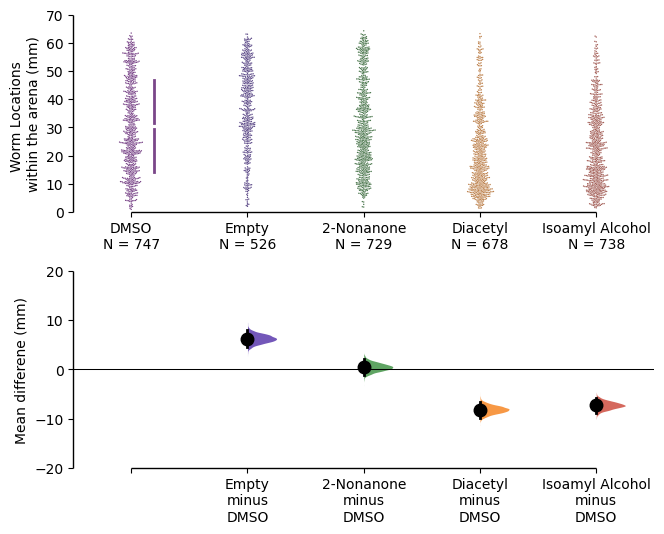

In [28]:
mm_refs_plot = mm_refs_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(0,70), custom_palette=agg_color_dict)



In [29]:
mm_refs_plot.savefig('/Volumes/LaCie/_2021_03_screen/aggregated_refs_mm.png')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


AttributeError: 'Dabest' object has no attribute 'statistics'

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


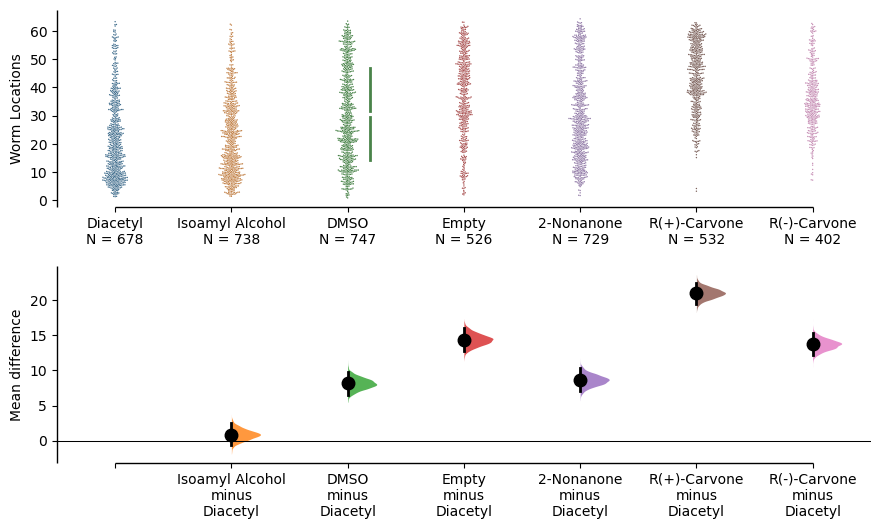

In [73]:
pos_comps_obj = dabest.load(mm_df, idx=(pos))
pos_comps_plot = pos_comps_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations')


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


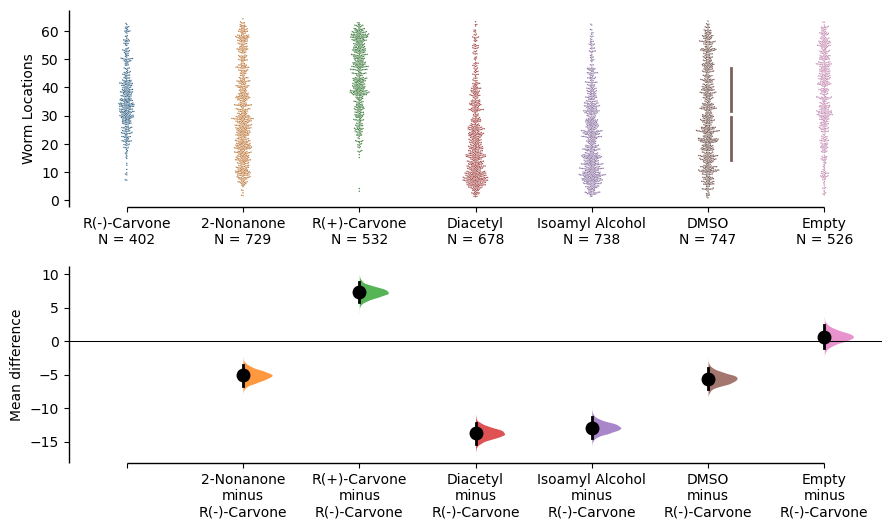

In [74]:
neg_comps_obj = dabest.load(mm_df, idx=(neg))
neg_comps_plot = neg_comps_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


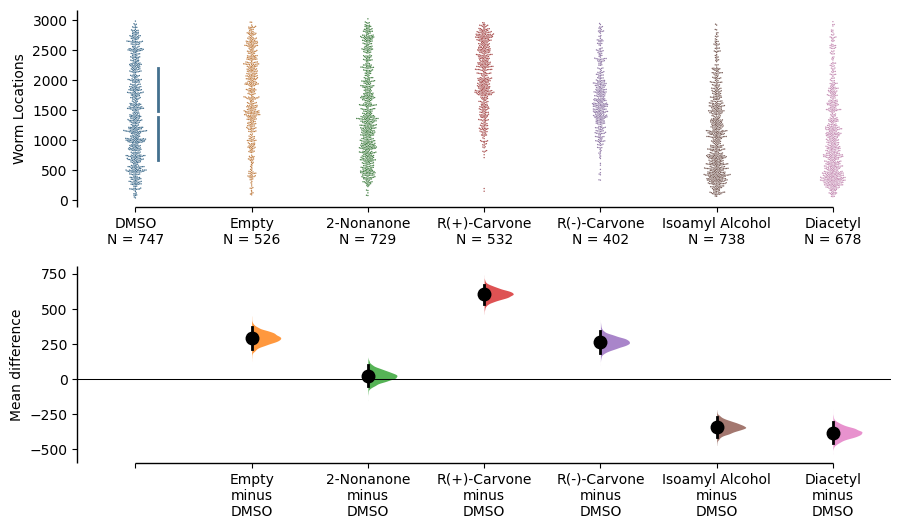

In [64]:
ref_comps_obj = dabest.load(ref_df, idx=(ref_comps))
ref_comps_plot = ref_comps_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations', )


In [47]:
ref_comps_obj.mean_diff

DABEST v0.2.6
             
Good morning!
The current time is Tue May 11 09:46:39 2021.

The unpaired mean difference between DMSO and Empty is 2.94e+02 [95%CI 2.11e+02, 3.73e+02].
The two-sided p-value of the Mann-Whitney test is 7.68e-12.

The unpaired mean difference between DMSO and 2-Nonanone is 23.0 [95%CI -52.6, 1.02e+02].
The two-sided p-value of the Mann-Whitney test is 0.567.

The unpaired mean difference between DMSO and R(+)-Carvone is 6.06e+02 [95%CI 5.33e+02, 6.74e+02].
The two-sided p-value of the Mann-Whitney test is 5.38e-44.

The unpaired mean difference between DMSO and R(-)-Carvone is 2.63e+02 [95%CI 1.88e+02, 3.41e+02].
The two-sided p-value of the Mann-Whitney test is 6.23e-10.

The unpaired mean difference between DMSO and Isoamyl Alcohol is -3.43e+02 [95%CI -4.15e+02, -2.69e+02].
The two-sided p-value of the Mann-Whitney test is 9.52e-18.

The unpaired mean difference between DMSO and Diacetyl is -3.83e+02 [95%CI -4.59e+02, -3.07e+02].
The two-sided p-value of t

In [43]:
ref_comps_plot.savefig('/Volumes/LaCie/_2021_03_screen/aggregated_refs.png')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


In [33]:
indy_reps = pd.read_csv('/Volumes/LaCie/_2021_03_screen/refs_sep_reps.csv')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


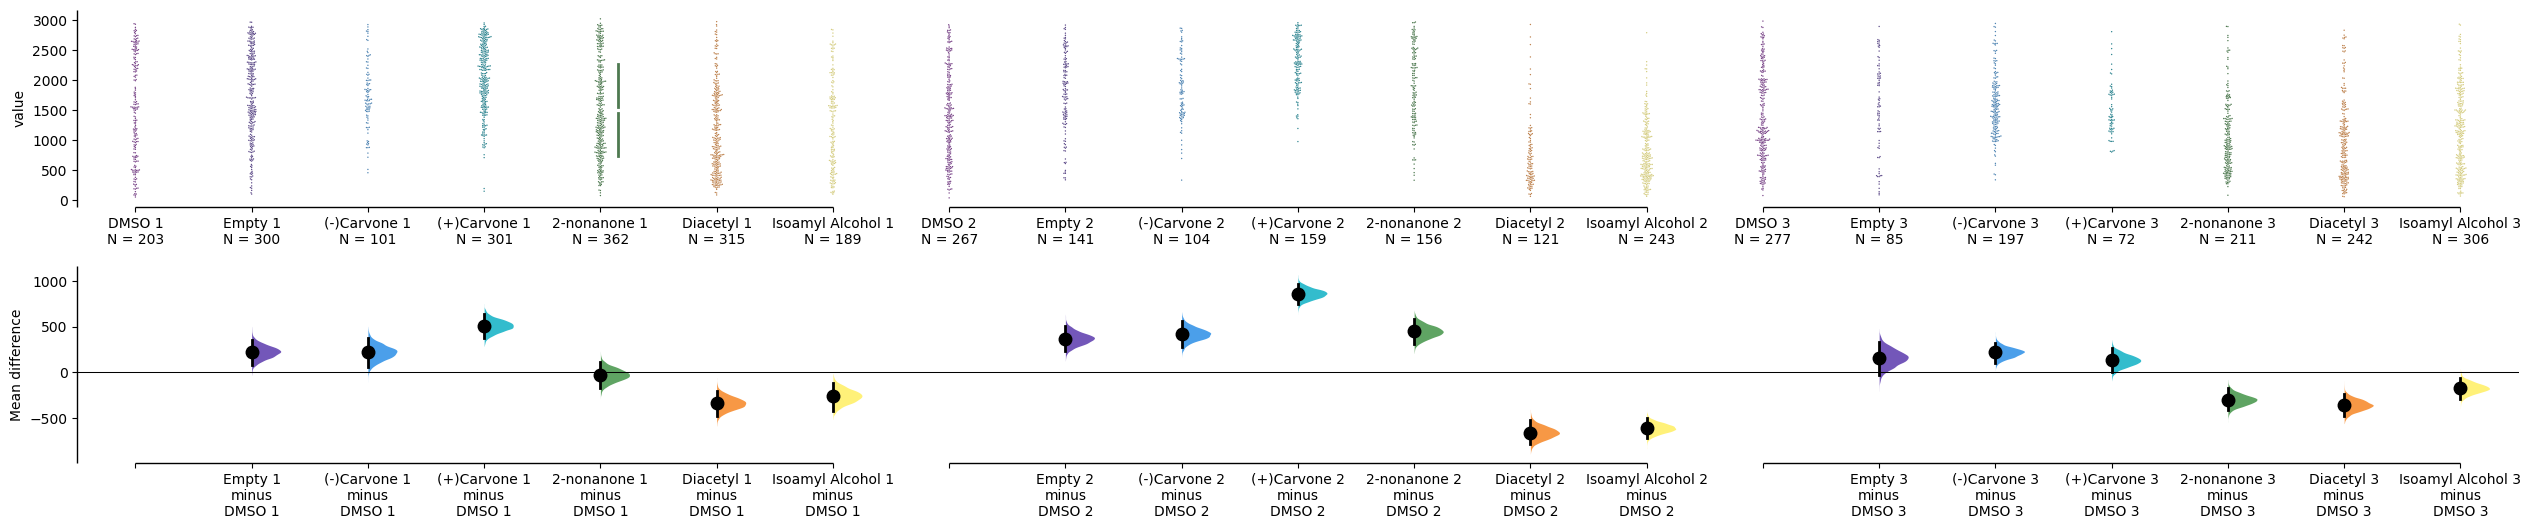

In [51]:
sep_reps_obj = dabest.load(indy_reps, idx=(('DMSO 1','Empty 1','(-)Carvone 1','(+)Carvone 1','2-nonanone 1', 'Diacetyl 1','Isoamyl Alcohol 1'),('DMSO 2','Empty 2','(-)Carvone 2','(+)Carvone 2','2-nonanone 2','Diacetyl 2','Isoamyl Alcohol 2'),('DMSO 3','Empty 3','(-)Carvone 3','(+)Carvone 3','2-nonanone 3','Diacetyl 3','Isoamyl Alcohol 3')))
sep_refs_plot=sep_reps_obj.mean_diff.plot(raw_marker_size=1, custom_palette=ref_color_dict)

In [90]:
ref_color_dict = {'DMSO 1': '#8E24AA' ,'Empty 1':'#512DA8','(-)Carvone 1': '#1E88E5','(+)Carvone 1': '#00ACC1','2-nonanone 1': '#388E3C' , 'Diacetyl 1': '#F57F17','Isoamyl Alcohol 1':'#CB4335', 'DMSO 2':'#8E24AA' ,'Empty 2': '#512DA8','(-)Carvone 2': '#1E88E5','(+)Carvone 2':'#00ACC1','2-nonanone 2':'#388E3C','Diacetyl 2':'#F57F17','Isoamyl Alcohol 2':'#CB4335','DMSO 3': '#8E24AA','Empty 3':'#512DA8','(-)Carvone 3': '#1E88E5', '(+)Carvone 3': '#00ACC1','2-nonanone 3':'#388E3C','Diacetyl 3':'#F57F17','Isoamyl Alcohol 3':'#CB4335'}



/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


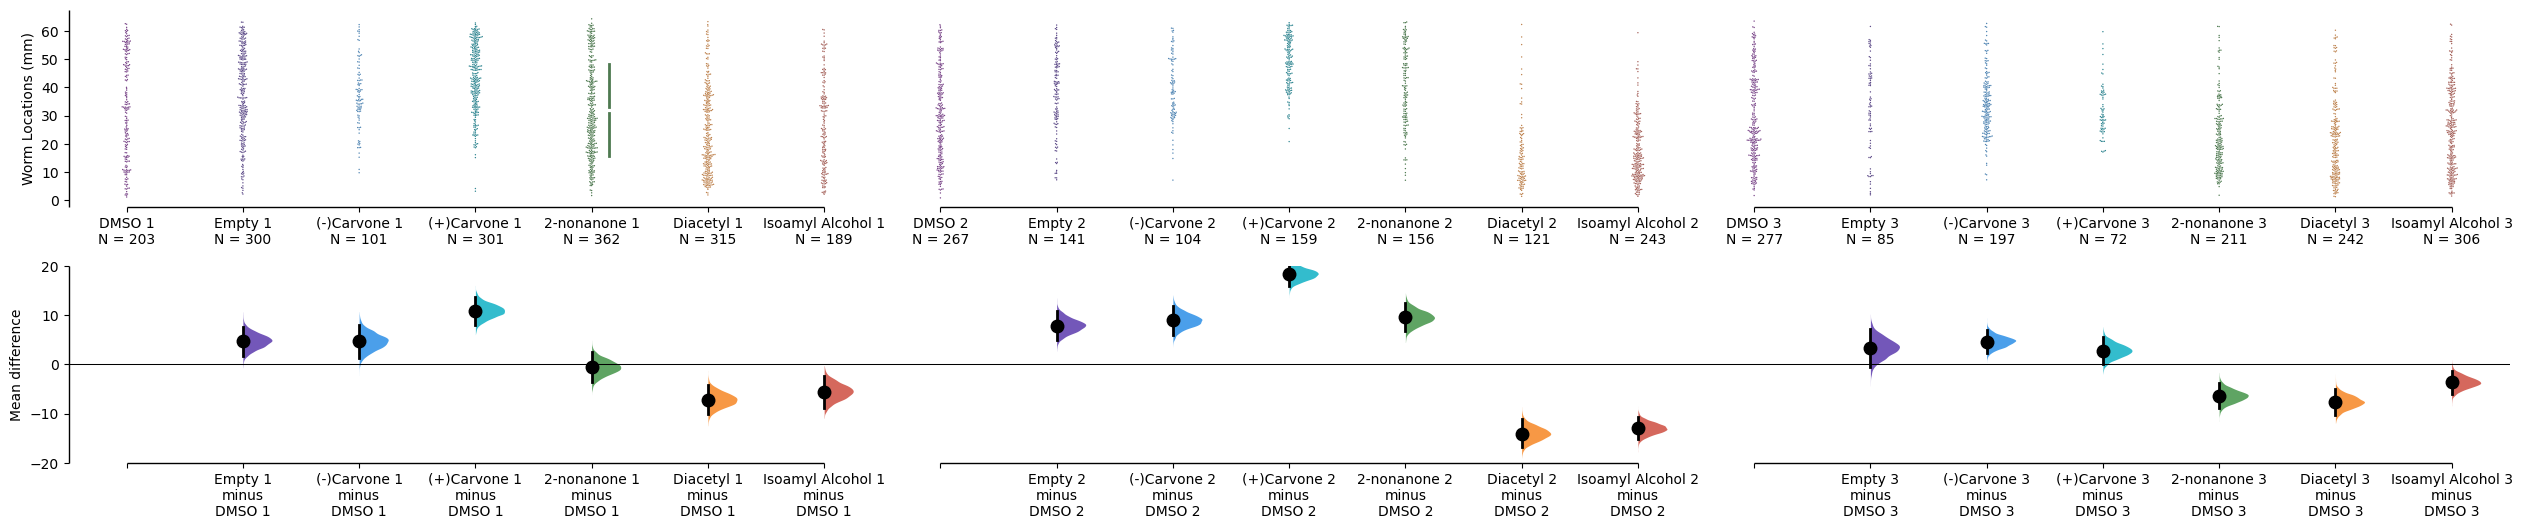

In [85]:
indy_reps_mm = indy_reps.apply(lambda x: x/47)
sep_reps_mm_obj = dabest.load(indy_reps_mm, idx=(('DMSO 1','Empty 1','(-)Carvone 1','(+)Carvone 1','2-nonanone 1', 'Diacetyl 1','Isoamyl Alcohol 1'),('DMSO 2','Empty 2','(-)Carvone 2','(+)Carvone 2','2-nonanone 2','Diacetyl 2','Isoamyl Alcohol 2'),('DMSO 3','Empty 3','(-)Carvone 3','(+)Carvone 3','2-nonanone 3','Diacetyl 3','Isoamyl Alcohol 3')))
sep_refs_mm_plot=sep_reps_mm_obj.mean_diff.plot(raw_marker_size=1, custom_palette=ref_color_dict, group_summaries=None, swarm_label = 'Worm Locations (mm)', contrast_ylim = (-20,20))


In [86]:
sep_refs_mm_plot.savefig('/Volumes/LaCie/_2021_03_screen/sep_reps_mm.png')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


## Subsetting Salv A analogs for Tessa

In [40]:
salv_color_dict = {'DMSO': '#8E24AA' ,'A Propionate':'#512DA8','A Carbamate': '#388E3C' , 'Salv B': '#F57F17'}
salv_comps = ['DMSO', 'Salvinorin A Propionate', 'Salvinorin A Carbamate', 'Salvinorin B']

In [12]:
salv = screen_data.loc[screen_data['Compound Name'].isin(salv_comps)]

salv_dict = {}
for index, row in salv.iterrows():
    salv_locs = get_worm_locs(row, wrm_locs_fldr, salv_dict)
salv_df = pd.DataFrame.from_dict(salv_dict)
salv_df.head()

,Salvinorin A Propionate,Salvinorin B,DMSO,Salvinorin A Carbamate
0,1544.0,1967.0,568,1665.0
1,1325.0,2024.0,1803,1819.0
2,1008.0,1637.0,792,1532.0
3,1935.0,367.0,2215,1228.0
4,1282.0,939.0,1089,1280.0


In [13]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

mm_df = salv_df.apply(lambda x: x/47)


In [36]:
mm_df.columns = ['A Propionate', 'Salv B', 'DMSO', 'A Carbamate']
mm_df.head()

,A Propionate,Salv B,DMSO,A Carbamate
0,32.851064,41.851064,12.085106,35.425532
1,28.191489,43.063830,38.361702,38.702128
2,21.446809,34.829787,16.851064,32.595745
3,41.170213,7.808511,47.127660,26.127660
4,27.276596,19.978723,23.170213,27.234043


In [37]:
salvs = ['DMSO', 'A Propionate', 'A Carbamate', 'Salv B']

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


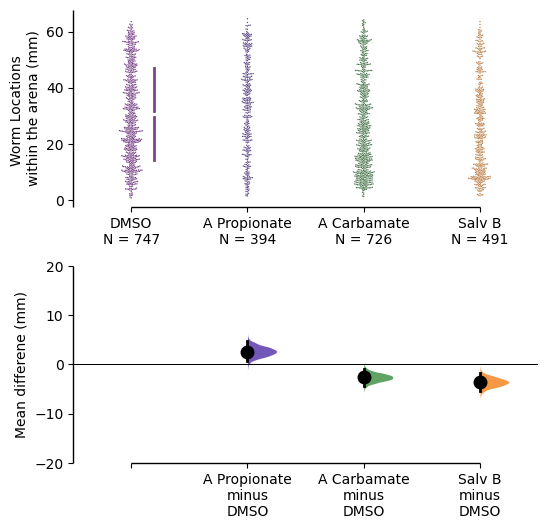

In [43]:
mm_refs_obj = dabest.load(mm_df, idx=salvs)

salv_refs_plot = mm_refs_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), custom_palette=salv_color_dict)

In [44]:
salv_refs_plot.savefig('/Volumes/LaCie/_2021_03_screen/pooled_salv_mm.png')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


In [45]:
sep_salv = pd.read_csv('/Volumes/LaCie/_2021_03_screen/salvA_sep.csv')
sep_salv.head()

,DMSO 1,A Propionate 1,A Carbamate 1,Salv B 1,DMSO 2,A Propionate 2,A Carbamate 2,Salv B 2,DMSO 3,A Propionate 3,A Carbamate 3,Salv B 3
0,568.0,1544.0,1665,1967.0,436.0,1705.0,792.0,609.0,472.0,1005.0,1242.0,2287.0
1,1803.0,1325.0,1819,2024.0,961.0,1913.0,474.0,402.0,378.0,2023.0,595.0,2492.0
2,792.0,1008.0,1532,1637.0,724.0,2676.0,959.0,381.0,670.0,1062.0,1258.0,1251.0
3,2215.0,1935.0,1228,367.0,1229.0,374.0,1639.0,1732.0,1282.0,345.0,341.0,2658.0
4,1089.0,1282.0,1280,939.0,1150.0,1242.0,1133.0,1929.0,1216.0,1089.0,871.0,1805.0


In [46]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

sep_salv_df = sep_salv.apply(lambda x: x/47)
sep_salv_df.head()

,DMSO 1,A Propionate 1,A Carbamate 1,Salv B 1,DMSO 2,A Propionate 2,A Carbamate 2,Salv B 2,DMSO 3,A Propionate 3,A Carbamate 3,Salv B 3
0,12.085106,32.851064,35.425532,41.851064,9.276596,36.276596,16.851064,12.957447,10.042553,21.382979,26.425532,48.659574
1,38.361702,28.191489,38.702128,43.063830,20.446809,40.702128,10.085106,8.553191,8.042553,43.042553,12.659574,53.021277
2,16.851064,21.446809,32.595745,34.829787,15.404255,56.936170,20.404255,8.106383,14.255319,22.595745,26.765957,26.617021
3,47.127660,41.170213,26.127660,7.808511,26.148936,7.957447,34.872340,36.851064,27.276596,7.340426,7.255319,56.553191
4,23.170213,27.276596,27.234043,19.978723,24.468085,26.425532,24.106383,41.042553,25.872340,23.170213,18.531915,38.404255


In [50]:
sep_salv_color_dict = {'DMSO 1': '#8E24AA' ,'A Propionate 1':'#512DA8','A Carbamate 1': '#388E3C' , 'Salv B 1': '#F57F17', 'DMSO 2': '#8E24AA' ,'A Propionate 2':'#512DA8','A Carbamate 2': '#388E3C' , 'Salv B 2': '#F57F17', 'DMSO 3': '#8E24AA' ,'A Propionate 3':'#512DA8','A Carbamate 3': '#388E3C' , 'Salv B 3': '#F57F17'}


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


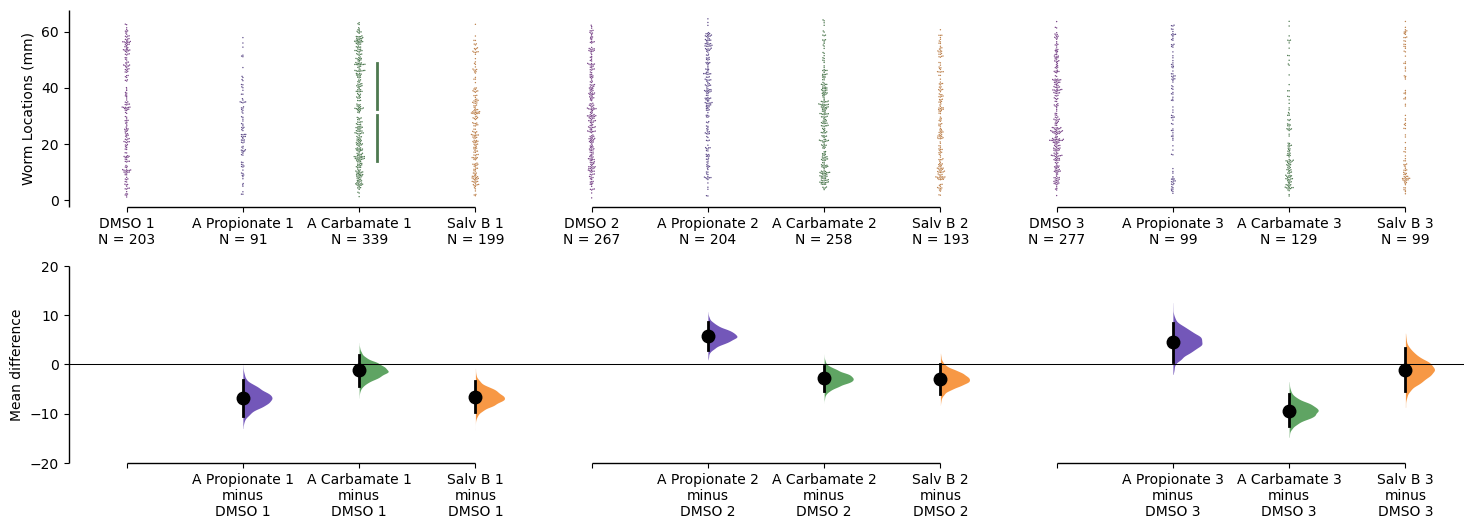

In [51]:
sep_salv_mm_obj = dabest.load(sep_salv_df, idx=(('DMSO 1','A Propionate 1','A Carbamate 1','Salv B 1'),('DMSO 2','A Propionate 2','A Carbamate 2','Salv B 2'),('DMSO 3','A Propionate 3','A Carbamate 3','Salv B 3')))
sep_salv_mm_plot=sep_salv_mm_obj.mean_diff.plot(raw_marker_size=1, group_summaries=None, swarm_label = 'Worm Locations (mm)', contrast_ylim = (-20,20), custom_palette=sep_salv_color_dict)

In [53]:
sep_salv_mm_plot.savefig('/Volumes/LaCie/_2021_03_screen/sep_salv_mm.png')

/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.
